In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tslearn.preprocessing import TimeSeriesResampler
from Process_Functions import Bessel_Filter, Down_sampling, normalized_translocation, interplotation, Draw_Plot, normalized_time_axis, normalized_delta
from scipy.ndimage import gaussian_filter1d
import os


In [ ]:
'''
file_name:导入文件的名称 默认为多列时间-电流数据（参考1.xlsx中的格式）
start end 指定导入数据的范围 默认全部
upper lim lower lim 决定数据长度范围

sampling frequency:导入数据的采样频率 默认100(KHz)
cut_off_frequency:截止频率，决定滤波的程度默认2(KHz)
drop head drop_tail 去掉处理后数据的前后几个数据点（由于采用的分离过孔信号方法，前后会产生很高的数据点）默认去掉5个数据点
smooth:是否使用高斯滤波器平滑数据，默认否
normalization_method 决定是-均值/标准差‘standard’还是‘delta’（deltaI/I_0,默认为standard）
'''
def Signal_Processing(file_name,start=None, end=None, upper_lim=None,lower_lim=1,sampling_frequency=100,cut_off_frequency=2,
                      drop_head=5,drop_tail=-5,smooth=False, normalization_method='standard',threshold=60):
    if file_name[-3:]=='lsx':
        original_data=pd.read_excel(file_name)
        
    elif file_name[-3:]=='csv':
        original_data=pd.read_csv(file_name)
    original_data = original_data.filter(regex='^(?!Unnamed)')
    signal_index = [int(col) for n, col in enumerate(original_data.columns) if (n + 1) % 3 == 1]  
    data_cleared=original_data.dropna(axis=1,how='all')
    #slice different serieses
    data_sliced = []
    column_num = len(data_cleared.columns)

    for i in range(0, column_num, 2):
        df_sliced = data_cleared.iloc[:, i:i+2].copy()  
        df_sliced.columns = ['t', 'i' ]
        # 删除所有值为空的行
        new_df_sliced = df_sliced.dropna(axis=0, how="all").copy()
        # 确保 new_df_sliced 不是空的再进行操作
        if not new_df_sliced.empty:
            new_df_sliced.loc[:, new_df_sliced.columns[0]] -= new_df_sliced.iloc[0, 0]
        data_sliced.append(new_df_sliced)

        
    #process the data
    #set parameters
    processed_data=[]
    for series in data_sliced:
        filtered_current=Bessel_Filter(series['i'],sampling_frequency=sampling_frequency,cut_off_frequency=cut_off_frequency)
        filtered_curve=np.array([series['t'],filtered_current])
        down_sampled_curve=filtered_curve
        filtered_curve_dataframe=pd.DataFrame(down_sampled_curve.T,columns=['t','i'])
        if normalization_method=='standard':
            normalized_data=normalized_translocation(filtered_curve_dataframe,threshold=min(filtered_curve_dataframe.iloc[:,1])+threshold,drop_head=drop_head, drop_tail=drop_tail)
            processed_data.append(normalized_data)
        elif normalization_method=='delta':
            normalized_data=normalized_delta(filtered_curve_dataframe,threshold=min(filtered_curve_dataframe.iloc[:,1])+threshold,drop_head=drop_head, drop_tail=drop_tail)
            processed_data.append(normalized_data)

    #select data for further alignment
    if upper_lim is None:
        target_data=processed_data
   
    else:
        target_data=[series for series in processed_data if len(series)<upper_lim and len(series)>lower_lim]
        selected_index=[]
        for index, series in enumerate(processed_data):
            if len(series) < upper_lim and len(series) > lower_lim:
                selected_index.append(index)
        selected_signal_index=[signal_index[i] for i in selected_index]
        
                
    
    #get the length of each selected signal and 
    len_target_data=[len(series) for series in target_data]
    #max_len=max(len_target_data)
    #max_index=[len(series) for series in target_data].index(max_len) 

    #using time_axis normalization method to normallize the time 
    if smooth==True:
        for series in target_data:
            series['i']=gaussian_filter1d(series['i'].values,sigma=3)

    
    time_normalized_data=[normalized_time_axis(series) for series in target_data][start:end]

    
    return  time_normalized_data,selected_signal_index

In [4]:

from tslearn.metrics import dtw_path, dtw
from tslearn.preprocessing import TimeSeriesResampler
import seaborn as sns


In [5]:

def dtw_alignment(time_normalized_data,signal_index=None,resample_length=None,plot_series=False,
                  plot_alignment=False,show_matrix=False, series_standard=None,smooth=False,constraint=None,method='classic',sakoe_radius=100,
                  target_path=None, inverse=False):
    if method=='classic':
        if series_standard is None:
            
            dtw_matrix=np.zeros((len(time_normalized_data),len(time_normalized_data)))

            for i in range(len(time_normalized_data)-1):
                for j in range (i+1, len(time_normalized_data)):
                    series_1=time_normalized_data[i]
                    series_2=time_normalized_data[j]
                    distance=dtw(series_1,series_2)
                    normalized_distance=distance/(len(series_1)+len(series_2))
                    dtw_matrix[i,j]=normalized_distance
                    dtw_matrix[j,i]=normalized_distance
            rows_sums=dtw_matrix.sum(axis=1)
            min_index=np.argmin(rows_sums)
            if signal_index is not None:
                print(signal_index[min_index])
            normalized_dtw_matrix=dtw_matrix/np.amax(dtw_matrix)
            if show_matrix==True:
                sns.heatmap(normalized_dtw_matrix, annot=False, fmt=".2f", cmap="YlGnBu")
                plt.show()
                print(len(rows_sums),min_index)
        else:
            pass

        aligned_data=[]
        if series_standard is None:
            series_standard=time_normalized_data[min_index]
            np_series_standard=series_standard.to_numpy()
            np_series_standard_time=np_series_standard[:,0].T
            np_series_standard_current=np_series_standard[:,1].T
        else:
            series_standard=series_standard
            np_series_standard=series_standard.to_numpy()
            np_series_standard_time=np_series_standard[:,0].T
            np_series_standard_current=np_series_standard[:,1].T
            
            
        for i in range(len(time_normalized_data)):
            
            series=time_normalized_data[i]
            standard_series=np_series_standard
            path,_=dtw_path(series,series_standard)
            if constraint is  None:
                path,_=dtw_path(series,series_standard)
                
            elif constraint=="sakoe_chiba":
                path,_=dtw_path(series,series_standard,global_constraint=constraint, sakoe_chiba_radius=sakoe_radius)
            aligned_series=np.zeros((len(path),2))
            aligned_standard_series=np.zeros((len(path),2))
            for i, (idx1, idx2) in enumerate(path):
                np_series=series.to_numpy()
                aligned_series[i] = np_series[idx1]
                aligned_standard_series[i]=standard_series[idx2]
            #aligned_series_time=[x[0] for x in aligned_series]
            aligned_series_current=[x[1] for x in aligned_series]
            aligned_standard_series_time=[x[0] for x in aligned_standard_series]
            aligned_data.append(np.array([aligned_standard_series_time,aligned_series_current]))
        
        aligned_data_unique=[]
            
        for series in aligned_data:
            unique_series_time,idx=np.unique(series[0,:],return_index=True)
            unique_series_current=series[1,:][idx]
            
            if smooth==True:
                unique_series_current=gaussian_filter1d(unique_series_current,sigma=5)

            if inverse==False:
                aligned_data_unique.append(np.array([unique_series_time,unique_series_current]))
            else:
                aligned_data_unique.append(np.array([unique_series_time,np.flip(unique_series_current)]))  
        

            
        if plot_alignment==True:
            for index, series in enumerate(aligned_data_unique):
                
                if signal_index is None:                   
                        plt.plot(series[0,:], series[1,:],label=str(index))                       
                else:                          
                        plt.plot(series[0,:], series[1,:],label=str(signal_index[index]))

     
                
                if target_path is not None:
                    plt.savefig(os.path.join(target_path,'radius'+str(sakoe_radius)+'.png'))
            if target_path is not None:
                plt.close('all')
            else:
                plt.legend(fontsize=4)
                plt.show()
        len_aligned_data=np.array([series.shape[1] for series in aligned_data_unique])
        max_aligned_len=len_aligned_data.max()
        max_len_index=np.argmax(len_aligned_data)


        resampler=TimeSeriesResampler(sz=max_aligned_len if resample_length is None else resample_length)
        
        interplotation_aligned_data=[resampler.fit_transform(series[-1,:]).ravel() for series in aligned_data_unique]

        average_current=np.sum(interplotation_aligned_data,axis=0)
        average_current/=len(interplotation_aligned_data)
    
            
        return aligned_data_unique, average_current

In [6]:
from tslearn.metrics import gamma_soft_dtw, soft_dtw
from tslearn.barycenters import softdtw_barycenter

import time

In [7]:

def barycenter_plot(data,target_length=500, start=None,end=None,gamma=None,inverse=False, 
                    choose_color='red',plot=False,max_iter=50,tol=1e-3):
    if target_length is None:
        target_length=max([series.shape[0] for series in data])
        resampler=TimeSeriesResampler(sz=target_length)
    else:  
        resampler=TimeSeriesResampler(sz=target_length)
    currents_resampled=[resampler.fit_transform(series).ravel() for series in data[start:end]]
# 调用 softdtw_barycenter 函数计算重心
    if gamma is None:
        gamma_select=[]
        for i in range(5):
            gamma_select.append(gamma_soft_dtw(currents_resampled[:], len(currents_resampled),i ))
        gamma= np.mean(gamma_select)
        print(f'auto_gamma:{gamma:.3f}')
        
    barycenter = softdtw_barycenter(currents_resampled, gamma=gamma,max_iter=max_iter,tol=tol)
    if inverse==True:
        barycenter=np.flip(barycenter)
    else:
        pass
    time=np.linspace(0,1,target_length)
    time_series=[np.array([time,barycenter.ravel()])]   

    return currents_resampled,barycenter,time_series

In [8]:
def comparison_plot(series1=None,series2=None,flip=False,export=False,file_name='',save_path='data export'):
    time_1=np.linspace(0,1, len(series1))  
    time_2=np.linspace(0,1, len(series2))    
    plt.plot(time_1,series1,color='red',label='direction_1')
    
    if flip==True:
        plt.plot(time_2, np.flip(series2),color='blue',label='direction_2')
    else:
        
        plt.plot(time_2,series2,color='blue')
    plt.show()

Import and Process Data

In [9]:
current_dir=os.getcwd()
dir_final='data_final'
direction_1='direction_1.xlsx'
direction_2='direction_2.xlsx'

In [10]:
time_normalized_data_1,selected_signal_index_1=Signal_Processing(os.path.join(current_dir,dir_final,direction_1),upper_lim=700,lower_lim=200,
                                        cut_off_frequency=5,normalization_method='standard',smooth=False,threshold=60)

In [11]:
time_normalized_data_2,selected_signal_index_2=Signal_Processing(os.path.join(current_dir,dir_final,direction_2),upper_lim=700,lower_lim=200,
                                        cut_off_frequency=5,normalization_method='standard',smooth=False,threshold=60)

In [12]:
print(len(time_normalized_data_1),len(time_normalized_data_2))

37 40


(array([2., 1., 1., 1., 3., 0., 2., 0., 3., 2., 3., 2., 1., 1., 1., 0., 3.,
        1., 1., 2., 2., 1., 0., 1., 1., 0., 0., 0., 1., 1.]),
 array([212., 228., 244., 260., 276., 292., 308., 324., 340., 356., 372.,
        388., 404., 420., 436., 452., 468., 484., 500., 516., 532., 548.,
        564., 580., 596., 612., 628., 644., 660., 676., 692.]),
 <BarContainer object of 30 artists>)

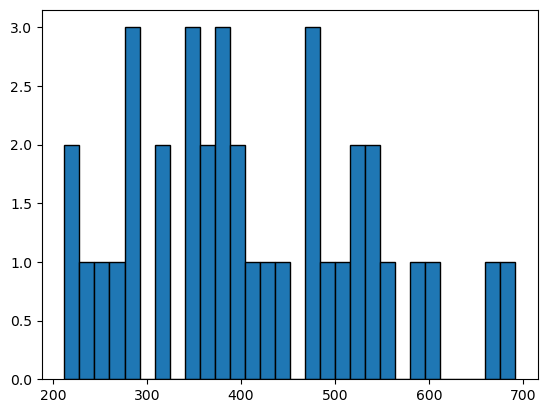

In [13]:
plt.hist([series.shape[0] for series in time_normalized_data_1], bins=30,  edgecolor='black')

(array([3., 2., 3., 2., 2., 2., 0., 0., 0., 2., 1., 3., 0., 2., 2., 1., 1.,
        2., 1., 1., 0., 1., 3., 0., 0., 0., 2., 3., 0., 1.]),
 array([204.        , 219.13333333, 234.26666667, 249.4       ,
        264.53333333, 279.66666667, 294.8       , 309.93333333,
        325.06666667, 340.2       , 355.33333333, 370.46666667,
        385.6       , 400.73333333, 415.86666667, 431.        ,
        446.13333333, 461.26666667, 476.4       , 491.53333333,
        506.66666667, 521.8       , 536.93333333, 552.06666667,
        567.2       , 582.33333333, 597.46666667, 612.6       ,
        627.73333333, 642.86666667, 658.        ]),
 <BarContainer object of 30 artists>)

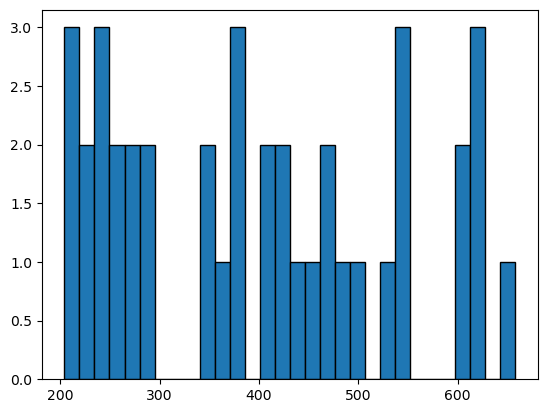

In [14]:
plt.hist([series.shape[0] for series in time_normalized_data_2], bins=30,  edgecolor='black')

In [15]:
aligned_data_unique_1,_=dtw_alignment(time_normalized_data_1,signal_index=selected_signal_index_1,plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=100,target_path=None,inverse=False)

36


In [16]:
aligned_data_unique_2,_=dtw_alignment(time_normalized_data_2,signal_index=selected_signal_index_2,plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=100,target_path=None,inverse=False)

61


Draw the Plot

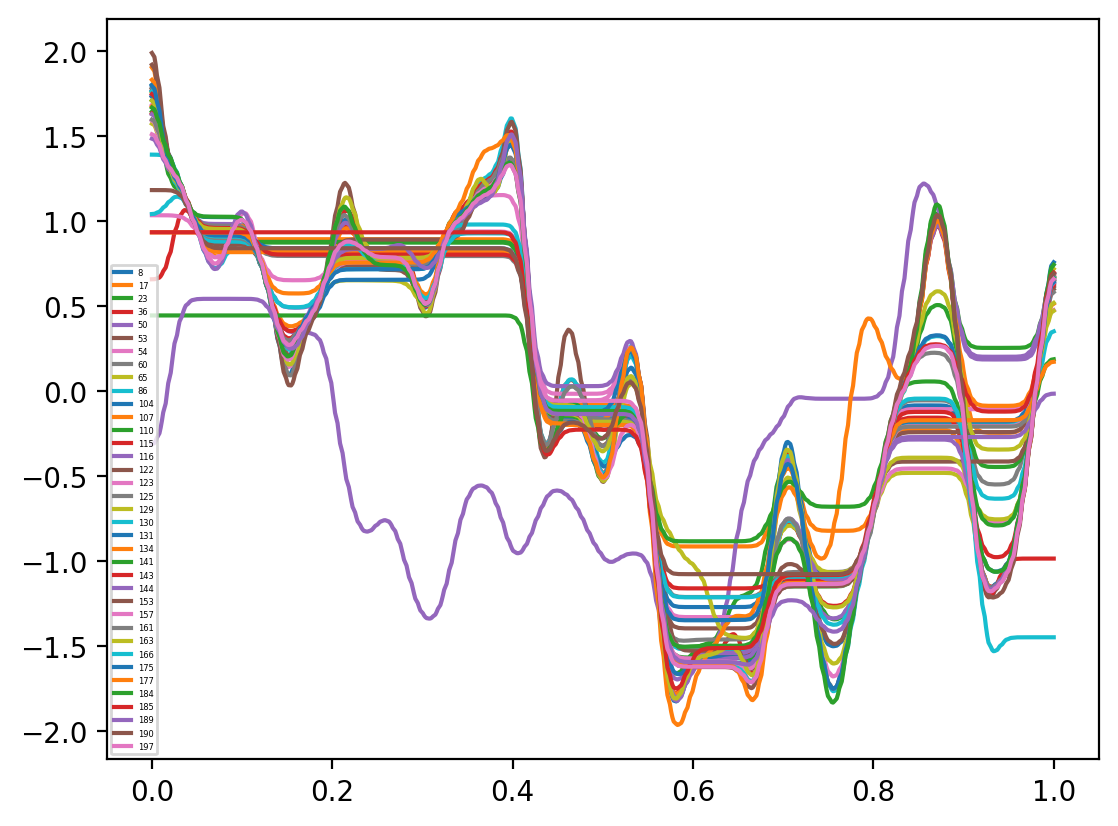

In [17]:
plt.rcParams['figure.dpi'] = 200
for index, series in enumerate(aligned_data_unique_1):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=5) ,label=str(selected_signal_index_1[index]))

plt.legend(fontsize=3)
plt.show()

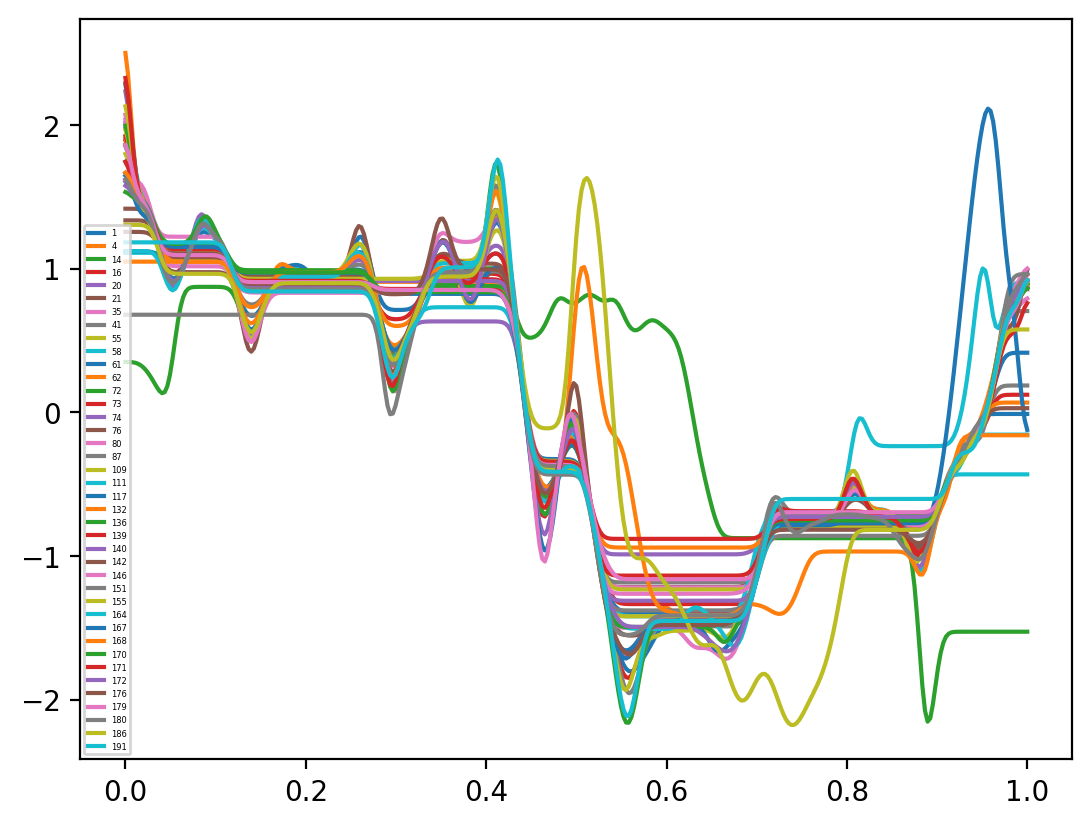

In [42]:
plt.rcParams['figure.dpi'] = 200
for index, series in enumerate(aligned_data_unique_2):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=2.5),label=str(selected_signal_index_2[index]))

plt.legend(fontsize=3)
plt.show()

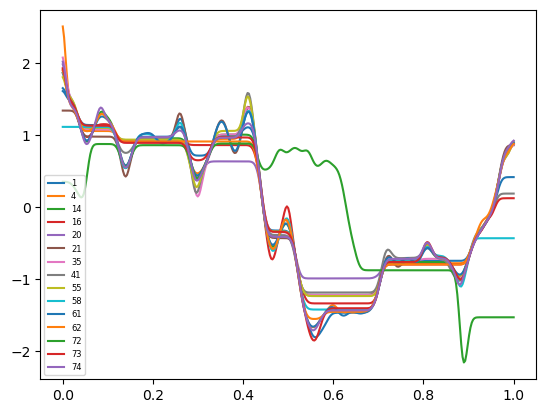

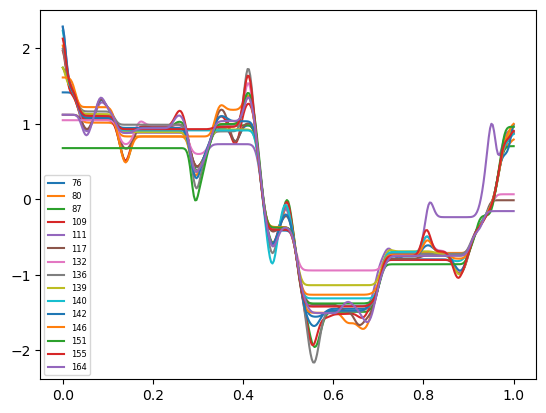

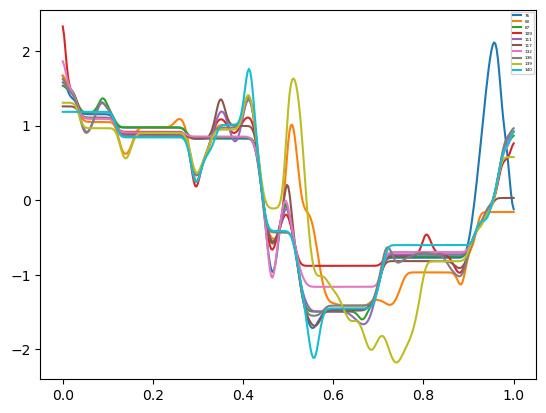

In [19]:
num_groups = len(aligned_data_unique_2) // 15
for group_idx in range(num_groups):
    start = group_idx * 15
    end = (group_idx + 1) * 15
    group_data = aligned_data_unique_2[start:end]
    group_index = selected_signal_index_2[start:end]

    for index, series in enumerate(group_data):
        x = series[0, :]
        y = gaussian_filter1d(series[1, :], sigma=2.5)

        plt.plot(x, y, label=str(group_index[index]))
    plt.legend(fontsize=6)
    plt.show()

# 处理剩余不足 15 个的数据
remaining_start = num_groups * 15
remaining_data = aligned_data_unique_2[remaining_start:]
remaining_index = selected_signal_index_2[remaining_start:]
if remaining_data:
    for index, series in enumerate(remaining_data):
        x = series[0, :]
        y = gaussian_filter1d(series[1, :], sigma=2.5)
        plt.plot(x, y, label=str(group_index[index]))

plt.legend(fontsize=3)
plt.show()

Barycenter Plot

In [20]:
def barycenter_process(data,target_length=500):
    data_current=[series.to_numpy().T[1,:] for series in data]
    _,barycenter,time_series=barycenter_plot([gaussian_filter1d(series,sigma=5) for series in data_current],target_length=target_length,
                                                                    gamma=0.5,max_iter=500)
    data_time=np.linspace(0,1,len(barycenter))
    data_standard_series=pd.DataFrame({'t':data_time,'i':barycenter.ravel()})
    _,average_signal=dtw_alignment(data,series_standard= data_standard_series)
    return average_signal

    

In [21]:
average_signal_1=barycenter_process(time_normalized_data_1,target_length=500)

In [22]:
average_signal_2=barycenter_process(time_normalized_data_2)

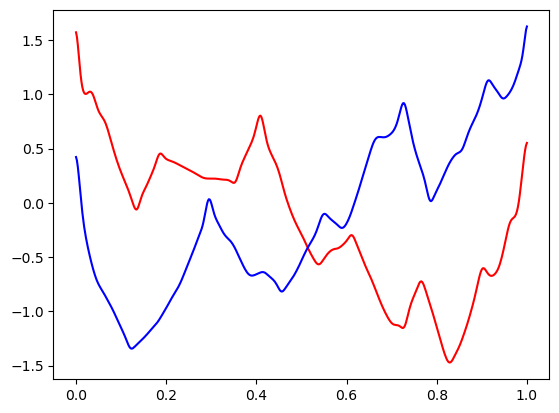

In [23]:
comparison_plot(series1=gaussian_filter1d(average_signal_1,sigma=3) ,series2=gaussian_filter1d(average_signal_2,sigma=3),flip=True)

DTW barycenter Random test

In [24]:
import random
def random_grouping(lst, group_size=20, seed_value=42):
    indexed_lst = [(i, value) for i, value in enumerate(lst)]
    random.seed(seed_value)
    random.shuffle(indexed_lst)
    groups = []
    original_indices_groups = []
    for i in range(0, len(indexed_lst), group_size):
        group = indexed_lst[i:i + group_size]
        original_indices = [index for index, _ in group]
        values = [value for _, value in group]
        groups.append(values)
        original_indices_groups.append(original_indices)
    return groups, original_indices_groups

In [25]:
from tslearn.preprocessing import TimeSeriesResampler
def average_current(data,resample_length=None):   
    max_aligned_len=max([series.shape[1] for series in data])
    resampler=TimeSeriesResampler(sz=max_aligned_len if resample_length is None else resample_length)
    
    interplotation_aligned_data=[resampler.fit_transform(series[-1,:]).ravel() for series in data]

    average_current=np.sum(interplotation_aligned_data,axis=0)
    average_current/=len(interplotation_aligned_data)
    
        
    return average_current

In [26]:
direction_2_groups,direction_2_index=random_grouping(time_normalized_data_2,group_size=22,seed_value=42)
direction_2_original_index = [[selected_signal_index_2[i] for i in series] for series in direction_2_index]

In [27]:
barycenter_series_2=[]
for series in direction_2_groups:    
    barycenter_series_2.append(barycenter_process(series))

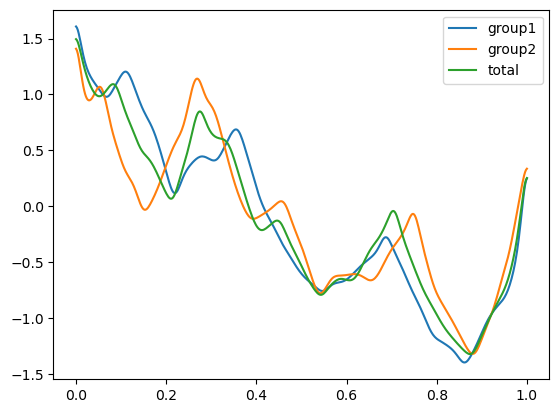

In [28]:
for group, series in enumerate(barycenter_series_2[:]):
    series_time=np.linspace(0,1,len(series))
    plt.plot(series_time,gaussian_filter1d(series,sigma=5),label='group'+str(group+1))
plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=5),label='total')
plt.legend()
plt.show()

DTW aligment for the three barycenter plot

In [29]:
soft_dtw_series_2=[]
for series in barycenter_series_2:
    series_time=np.linspace(0,1,len(series))
    soft_dtw_series_2.append(pd.DataFrame({'t':series_time,'i':series}))

    

In [30]:
standard_current=barycenter_series_2[1]
standard_series=pd.DataFrame({'t':np.linspace(0,1,len(standard_current)),'i':standard_current})

In [31]:
aligned_barycenter_2,_=dtw_alignment(soft_dtw_series_2,signal_index=None,plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=80,target_path=None,inverse=False,series_standard=None)

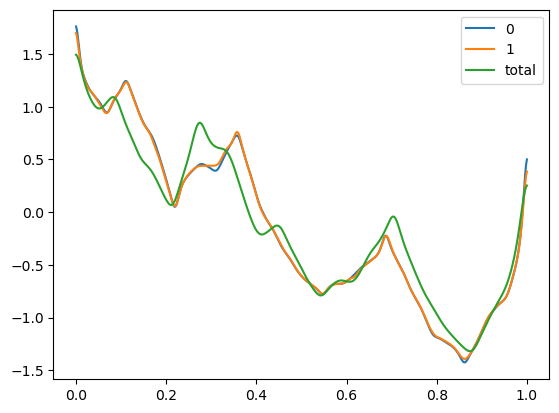

In [32]:
for index, series in enumerate(aligned_barycenter_2):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=3),label=str(index))

plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=5),label='total')

plt.legend(fontsize=10)
plt.show()

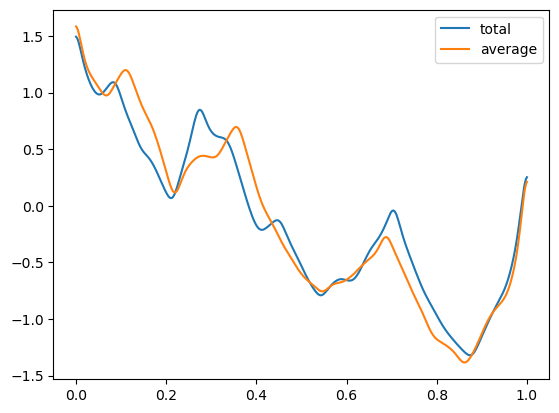

In [33]:
average_current_2=average_current(aligned_barycenter_2,resample_length=500)
plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=5),label='total')
plt.plot(np.linspace(0,1,len(average_current_2)),gaussian_filter1d(average_current_2,sigma=5),label='average')
plt.legend(fontsize=10)
plt.show()

Direction_1_Test

In [34]:
direction_1_groups,direction_1_index=random_grouping(time_normalized_data_1,group_size=22,seed_value=42)
direction_1_original_index = [[selected_signal_index_1[i] for i in series]  for series in direction_1_index]

In [35]:
barycenter_series_1=[]
for series in direction_1_groups:    
    barycenter_series_1.append(barycenter_process(series))

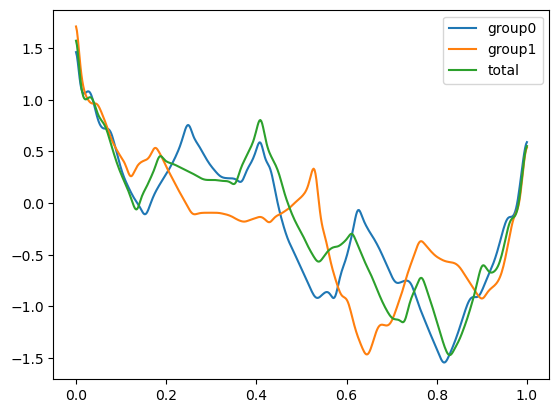

In [36]:
for group, series in enumerate(barycenter_series_1[:]):
    series_time=np.linspace(0,1,len(series))
    plt.plot(series_time,gaussian_filter1d(series,sigma=3),label='group'+str(group))
plt.plot(np.linspace(0,1,len(average_signal_1)),gaussian_filter1d(average_signal_1,sigma=3),label='total')
plt.legend()
plt.show()

In [37]:
soft_dtw_series_1=[]
for series in barycenter_series_1:
    series_time=np.linspace(0,1,len(series))
    soft_dtw_series_1.append(pd.DataFrame({'t':series_time,'i':series}))

In [38]:
aligned_barycenter_1,_=dtw_alignment(soft_dtw_series_1,signal_index=None,plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=80,target_path=None,inverse=False)

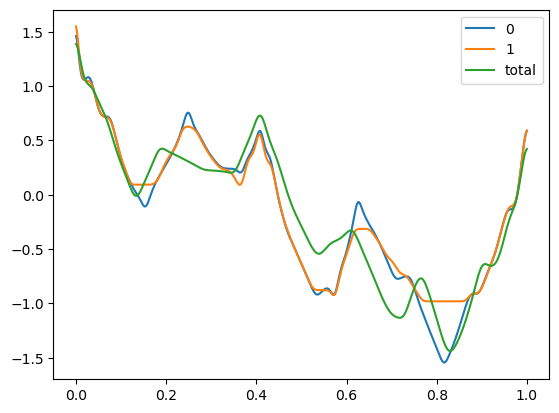

In [39]:
for index, series in enumerate(aligned_barycenter_1):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=3),label=str(index))

plt.plot(np.linspace(0,1,len(average_signal_1)),gaussian_filter1d(average_signal_1,sigma=5),label='total')
plt.legend(fontsize=10)
plt.show()

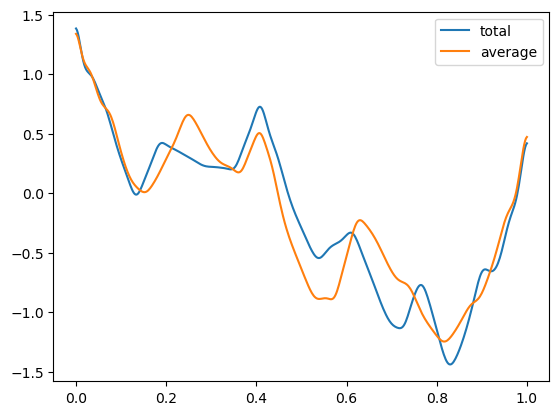

In [40]:
average_current_1 = average_current(aligned_barycenter_1, resample_length=500)
plt.plot(np.linspace(0, 1, len(average_signal_1)), gaussian_filter1d(average_signal_1, sigma=5), label='total')
plt.plot(np.linspace(0, 1, len(average_current_1)), gaussian_filter1d(average_current_1, sigma=5), label='average')
plt.legend(fontsize=10)
plt.show()

DTW alignment random test

In [41]:
aligned_data_set_2=[]
for group, series in enumerate(direction_2_groups):
    aligned_data_group,_=dtw_alignment(series,signal_index=direction_2_original_index[group],plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=100,target_path=None,inverse=False,series_standard=soft_dtw_series_2[group])
    aligned_data_set_2.append(aligned_data_group)
    

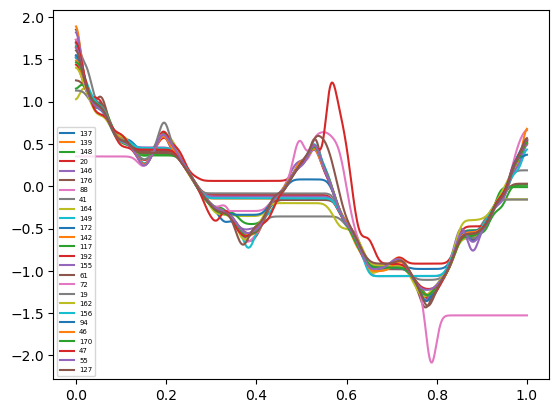

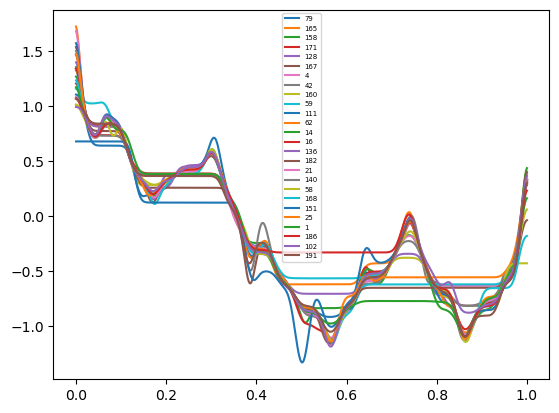

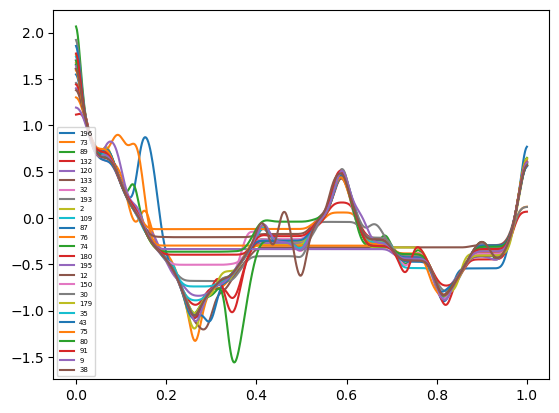

In [40]:
for ind,data in enumerate(aligned_data_set_2):
    for index, series in enumerate(data):
                
        plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=5) ,label=str(direction_2_original_index[ind][index]))

    plt.legend(fontsize=5)
    plt.show()


Export the signals

In [ ]:
def export_data(data,save_path='',file_name='1'):
    data_processed=[]
    for i in range(len(data)):
        series_index=pd.DataFrame([], columns=[str(i+1)])
        data_processed.append(series_index)
        if isinstance(data[0],np.ndarray):
            if data[0].ndim==1:
                data_processed.append(pd.DataFrame({'t':np.linspace(0,1,data[i].shape[1]).T,'i':data[i].T}))
            elif data[0].ndim==2:
                data_processed.append(pd.DataFrame(data[i].T,columns=['t','i']))
            else:
                print('TypeError, Please check data type')
        elif isinstance(data[0],pd.DataFrame):
            data_processed.append(data[i])
        else:
            print('TypeError, Please check data type')
            
            
    
#merge all the data 
    max_length = max([df.shape[0] for df in data_processed])

    # 填充每个 DataFrame 至最大行数
    for i, df in enumerate(data_processed):
        if df.shape[0] < max_length:
            num_missing = max_length - df.shape[0]
            missing_df = pd.DataFrame(index=range(num_missing), columns=df.columns)
            data_processed[i] = pd.concat([df, missing_df], ignore_index=True)

    # 水平拼接所有 DataFrame
    combined_df = pd.concat(data_processed, axis=1)

    # 导出为 Excel 文件
    cur_dir=os.getcwd()
    abs_save_path=os.path.join(cur_dir,save_path)
    if not os.path.exists(abs_save_path):
        os.makedirs(abs_save_path)
    combined_df.to_excel(os.path.join(abs_save_path,file_name+'.xlsx'), index=False)

In [ ]:
direction_1_export=[]
for series in barycenter_series_2:
    series_time=np.linspace(0,1,len(series))
    processed_current=gaussian_filter1d(series,sigma=3)
    direction_1_export.append(pd.DataFrame({'t':series_time,'i':processed_current}))
series_time=np.linspace(0,1,len(average_signal_2))
direction_1_export.append(pd.DataFrame({'t':series_time,'i':gaussian_filter1d(average_signal_2,sigma=3)}))
    


In [190]:
direction_2_aligned_export=[]
for series in aligned_barycenter_2:
    series_time=np.linspace(0,1,series.shape[1])
    processed_current=gaussian_filter1d(series[1,:],sigma=3).T
    direction_2_aligned_export.append(pd.DataFrame({'t':series_time,'i':processed_current}))
series_time=np.linspace(0,1,len(average_signal_2))
direction_2_aligned_export.append(pd.DataFrame({'t':series_time,'i':gaussian_filter1d(average_signal_2,sigma=3)}))

In [191]:
sec_path='final_export_data'
class_path='grouped_barycenter_aligned'
direction_path='direction_2'
export_data(direction_2_aligned_export,save_path=os.path.join(sec_path,class_path,direction_path),file_name='grouped_barycenter_aligned_2')